In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e1-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

snr_db_index = 2
snr_db=snr_db_array[snr_db_index]

Mounted at /content/drive


In [3]:
sample_range = range(600, 800)

Correlation-Aware Sparse Bayesian Learning (CA-SBL)

In [4]:
def casbl_algorithm(A, y, N, sig2e, Tau_p, loc, alpha=1.5, beta=0.2, kappa=5.725, D=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if kappa == 0:
        correlation_matrix = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / kappa) - np.exp(-D / kappa)) / (1 - np.exp(-D / kappa)),0)

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = A @ Gamma @ A.conj().T + sig2e * np.eye(Tau_p)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ A.conj().T @ Sigma_y_inv @ A @ Gamma
        mu_x = Gamma @ A.conj().T @ Sigma_y_inv @ y

        # Compute Q (denoted as B in the image)
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P (denoted as A_3 in the image)
        P = 2 * alpha * (beta - correlation_matrix) @ np.diag(Gamma)
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = A @ Gamma @ A.conj().T + sig2e * np.eye(Tau_p)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ A.conj().T @ Sigma_y_inv @ A @ Gamma
    mu_x = Gamma @ A.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [5]:
# Placeholder arrays for casbl results
z_casbl = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # casbl results
gamma_casbl = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # casbl gamma values
hit_rate_casbl = np.zeros((num_samples, len(pilot_length_array)))  # Hit rate for casbl
support_recovery_rate_casbl = np.zeros((num_samples, len(pilot_length_array)))  # Miss detection rate for casbl
false_alarm_rate_casbl = np.zeros((num_samples, len(pilot_length_array)))  # False alarm rate for casbl
norm_mse_casbl = np.zeros((num_samples, len(pilot_length_array)))  # Norm MSE for casbl

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # True gamma values (ground truth)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply casbl algorithm for the current sample and SNR level
        z_result, gamma_result = casbl_algorithm(theta, received_signal, device_count, noise_power, pilot_length, loc)

        # Store the results
        z_result[gamma_result <= 0.05] = 0
        z_casbl[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_casbl[sample_index, pilot_length_index, :] = gamma_result_bool

        # Avoid division by zero in hit/miss/false alarm rate calculations
        active_devices = np.sum(gamma == 1)  # True active devices
        inactive_devices = np.sum(gamma == 0)  # True inactive devices

        # Calculate the hit rate for casbl
        hit_rate_casbl[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # Calculate the support recovery rate for casbl
        support_recovery_rate_casbl[sample_index, pilot_length_index] = (
            np.sum((gamma_result_bool ==1) & (gamma == 1))
            /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Calculate the false alarm rate for casbl
        false_alarm_rate_casbl[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Calculate the normalized MSE for casbl
        norm_mse_casbl[sample_index, pilot_length_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )  # Avoid division by zero


Processing Pilot Length Levels:  50%|█████     | 3/6 [00:53<00:53, 17.83s/it]

Converged after 490 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:28, 14.02s/it]

Converged after 280 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:12, 12.59s/it]

Converged after 226 outer iterations



Processing Samples:   0%|          | 1/200 [01:26<4:45:20, 86.03s/it]

Converged after 251 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:33<01:06, 16.71s/it]

Converged after 493 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:51, 17.02s/it]

Converged after 497 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.01s/it]

Converged after 356 outer iterations



Processing Samples:   1%|          | 2/200 [03:01<5:02:41, 91.73s/it]

Converged after 284 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:54<00:54, 18.13s/it]

Converged after 490 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:29, 14.93s/it]

Converged after 288 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:13, 13.61s/it]

Converged after 296 outer iterations



Processing Samples:   2%|▏         | 3/200 [04:30<4:56:00, 90.15s/it]

Converged after 298 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:28, 14.32s/it]

Converged after 266 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.22s/it]

Converged after 351 outer iterations



Processing Samples:   2%|▏         | 4/200 [05:58<4:52:19, 89.49s/it]

Converged after 269 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.19s/it]

Converged after 430 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:00<00:28, 14.42s/it]

Converged after 283 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:13, 13.62s/it]

Converged after 280 outer iterations



Processing Samples:   2%|▎         | 5/200 [07:22<4:44:08, 87.43s/it]

Converged after 227 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.57s/it]

Converged after 393 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.24s/it]

Converged after 315 outer iterations



Processing Samples:   3%|▎         | 6/200 [08:52<4:46:01, 88.46s/it]

Converged after 234 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.80s/it]

Converged after 451 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.66s/it]

Converged after 359 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.44s/it]

Converged after 388 outer iterations



Processing Samples:   4%|▎         | 7/200 [10:24<4:47:34, 89.40s/it]

Converged after 282 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:31<01:03, 15.78s/it]

Converged after 446 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:49, 16.43s/it]

Converged after 481 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.79s/it]

Converged after 438 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.22s/it]

Converged after 331 outer iterations



Processing Samples:   4%|▍         | 8/200 [11:56<4:49:40, 90.52s/it]

Converged after 254 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:32<01:04, 16.19s/it]

Converged after 475 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:49, 16.66s/it]

Converged after 468 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.14s/it]

Converged after 323 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.09s/it]

Converged after 293 outer iterations



Processing Samples:   4%|▍         | 9/200 [13:22<4:42:45, 88.83s/it]

Converged after 222 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:47, 15.85s/it]

Converged after 392 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.66s/it]

Converged after 413 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.53s/it]

Converged after 288 outer iterations



Processing Samples:   5%|▌         | 10/200 [14:48<4:39:04, 88.13s/it]

Converged after 281 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:47<00:45, 15.13s/it]

Converged after 321 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:57<00:26, 13.25s/it]

Converged after 350 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.51s/it]

Converged after 354 outer iterations



Processing Samples:   6%|▌         | 11/200 [16:14<4:35:36, 87.49s/it]

Converged after 347 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:50, 16.89s/it]

Converged after 407 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:08<00:33, 16.78s/it]

Converged after 428 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.76s/it]

Converged after 348 outer iterations



Processing Samples:   6%|▌         | 12/200 [17:44<4:36:21, 88.20s/it]

Converged after 230 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.33s/it]

Converged after 481 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.70s/it]

Converged after 342 outer iterations



Processing Samples:   6%|▋         | 13/200 [19:22<4:43:59, 91.12s/it]

Converged after 241 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:30<01:01, 15.29s/it]

Converged after 414 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:44<00:43, 14.48s/it]

Converged after 358 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.90s/it]

Converged after 402 outer iterations



Processing Samples:   7%|▋         | 14/200 [20:53<4:42:02, 90.98s/it]

Converged after 273 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.05s/it]

Converged after 419 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.35s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.12s/it]

Converged after 269 outer iterations



Processing Samples:   8%|▊         | 15/200 [22:22<4:39:34, 90.67s/it]

Converged after 381 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:46<00:45, 15.05s/it]

Converged after 347 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:31, 15.69s/it]

Converged after 458 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.25s/it]

Converged after 260 outer iterations



Processing Samples:   8%|▊         | 16/200 [23:48<4:33:41, 89.25s/it]

Converged after 253 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.52s/it]

Converged after 379 outer iterations



Processing Samples:   8%|▊         | 17/200 [25:26<4:39:23, 91.60s/it]

Converged after 310 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:46<00:45, 15.17s/it]

Converged after 353 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:58<00:28, 14.05s/it]

Converged after 307 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.46s/it]

Converged after 389 outer iterations



Processing Samples:   9%|▉         | 18/200 [26:52<4:32:53, 89.97s/it]

Converged after 258 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.99s/it]

Converged after 493 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:37, 18.70s/it]

Converged after 326 outer iterations



Processing Samples:  10%|▉         | 19/200 [28:26<4:35:03, 91.18s/it]

Converged after 281 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.62s/it]

Converged after 449 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:31, 15.71s/it]

Converged after 333 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:17, 17.12s/it]

Converged after 483 outer iterations



Processing Samples:  10%|█         | 20/200 [30:02<4:38:37, 92.87s/it]

Converged after 266 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:44<00:42, 14.29s/it]

Converged after 284 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:00<00:30, 15.05s/it]

Converged after 437 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:12, 12.36s/it]

Converged after 250 outer iterations



Processing Samples:  10%|█         | 21/200 [31:23<4:25:36, 89.03s/it]

Converged after 250 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:54<00:55, 18.59s/it]

Converged after 491 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:36, 18.02s/it]

Converged after 466 outer iterations



Processing Samples:  11%|█         | 22/200 [33:06<4:37:17, 93.47s/it]

Converged after 326 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.03s/it]

Converged after 417 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.02s/it]

Converged after 344 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.17s/it]

Converged after 309 outer iterations



Processing Samples:  12%|█▏        | 23/200 [34:33<4:30:03, 91.55s/it]

Converged after 284 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.31s/it]

Converged after 375 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.97s/it]

Converged after 444 outer iterations



Processing Samples:  12%|█▏        | 24/200 [36:10<4:32:32, 92.91s/it]

Converged after 280 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:36<01:12, 18.04s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:53<00:52, 17.39s/it]

Converged after 464 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:31, 15.95s/it]

Converged after 358 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.74s/it]

Converged after 373 outer iterations



Processing Samples:  12%|█▎        | 25/200 [37:42<4:30:21, 92.70s/it]

Converged after 241 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:47<00:46, 15.34s/it]

Converged after 351 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.38s/it]

Converged after 414 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:12, 12.77s/it]

Converged after 272 outer iterations



Processing Samples:  13%|█▎        | 26/200 [39:04<4:19:29, 89.48s/it]

Converged after 238 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:49, 16.47s/it]

Converged after 461 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.48s/it]

Converged after 331 outer iterations



Processing Samples:  14%|█▎        | 27/200 [40:34<4:18:53, 89.79s/it]

Converged after 205 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.78s/it]

Converged after 330 outer iterations



Processing Samples:  14%|█▍        | 28/200 [42:14<4:25:52, 92.75s/it]

Converged after 314 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:30, 15.34s/it]

Converged after 310 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.50s/it]

Converged after 311 outer iterations



Processing Samples:  14%|█▍        | 29/200 [43:44<4:22:01, 91.94s/it]

Converged after 301 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.89s/it]

Converged after 492 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:32, 16.32s/it]

Converged after 393 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.58s/it]

Converged after 354 outer iterations



Processing Samples:  15%|█▌        | 30/200 [45:16<4:20:14, 91.85s/it]

Converged after 260 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.83s/it]

Converged after 342 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.33s/it]

Converged after 278 outer iterations



Processing Samples:  16%|█▌        | 31/200 [46:46<4:17:08, 91.30s/it]

Converged after 324 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.03s/it]

Converged after 417 outer iterations
Converged after 461 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.32s/it]

Converged after 345 outer iterations



Processing Samples:  16%|█▌        | 32/200 [48:15<4:14:18, 90.82s/it]

Converged after 232 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:49, 16.49s/it]

Converged after 457 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.55s/it]

Converged after 417 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.77s/it]

Converged after 312 outer iterations



Processing Samples:  16%|█▋        | 33/200 [49:45<4:12:03, 90.56s/it]

Converged after 281 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.58s/it]

Converged after 427 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.90s/it]

Converged after 403 outer iterations



Processing Samples:  17%|█▋        | 34/200 [51:24<4:17:34, 93.10s/it]

Converged after 309 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:47<00:46, 15.54s/it]

Converged after 376 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.01s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.32s/it]

Converged after 315 outer iterations



Processing Samples:  18%|█▊        | 35/200 [52:48<4:08:07, 90.23s/it]

Converged after 271 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:33, 16.79s/it]

Converged after 392 outer iterations



Processing Samples:  18%|█▊        | 36/200 [54:37<4:22:13, 95.94s/it]

Converged after 482 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:33<01:07, 16.82s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.76s/it]

Converged after 345 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.34s/it]

Converged after 430 outer iterations



Processing Samples:  18%|█▊        | 37/200 [56:15<4:21:56, 96.42s/it]

Converged after 376 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:28, 14.29s/it]

Converged after 265 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:12, 12.87s/it]

Converged after 229 outer iterations



Processing Samples:  19%|█▉        | 38/200 [57:39<4:10:19, 92.72s/it]

Converged after 269 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:51, 17.18s/it]

Converged after 482 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.54s/it]

Converged after 331 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.45s/it]

Converged after 280 outer iterations



Processing Samples:  20%|█▉        | 39/200 [59:05<4:03:38, 90.80s/it]

Converged after 232 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:50, 16.76s/it]

Converged after 446 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.53s/it]

Converged after 353 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:12, 12.84s/it]

Converged after 242 outer iterations



Processing Samples:  20%|██        | 40/200 [1:00:31<3:58:06, 89.29s/it]

Converged after 318 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:46<00:42, 14.27s/it]

Converged after 328 outer iterations
Converged after 411 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:16, 16.01s/it]

Converged after 403 outer iterations



Processing Samples:  20%|██        | 41/200 [1:02:01<3:57:06, 89.47s/it]

Converged after 300 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:53<00:52, 17.54s/it]

Converged after 480 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.85s/it]

Converged after 475 outer iterations



Processing Samples:  21%|██        | 42/200 [1:03:45<4:07:37, 94.03s/it]

Converged after 365 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.72s/it]

Converged after 490 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.17s/it]

Converged after 333 outer iterations



Processing Samples:  22%|██▏       | 43/200 [1:05:21<4:07:40, 94.65s/it]

Converged after 247 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.05s/it]

Converged after 428 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.68s/it]

Converged after 318 outer iterations
Converged after 223 outer iterations



Processing Samples:  22%|██▏       | 44/200 [1:06:40<3:53:32, 89.82s/it]

Converged after 228 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.87s/it]

Converged after 453 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.78s/it]

Converged after 475 outer iterations



Processing Samples:  22%|██▎       | 45/200 [1:08:21<4:00:39, 93.16s/it]

Converged after 270 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:46<00:45, 15.09s/it]

Converged after 354 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.12s/it]

Converged after 407 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:15, 15.01s/it]

Converged after 358 outer iterations



Processing Samples:  23%|██▎       | 46/200 [1:09:54<3:58:44, 93.02s/it]

Converged after 416 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:33<01:06, 16.60s/it]

Converged after 500 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.94s/it]

Converged after 448 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.16s/it]

Converged after 315 outer iterations



Processing Samples:  24%|██▎       | 47/200 [1:11:25<3:55:44, 92.45s/it]

Converged after 216 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:33, 16.83s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:15, 15.67s/it]

Converged after 315 outer iterations



Processing Samples:  24%|██▍       | 48/200 [1:13:01<3:57:27, 93.73s/it]

Converged after 319 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:29, 14.84s/it]

Converged after 270 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.02s/it]

Converged after 307 outer iterations



Processing Samples:  24%|██▍       | 49/200 [1:14:30<3:52:17, 92.30s/it]

Converged after 345 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:49, 16.47s/it]

Converged after 461 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.58s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.49s/it]

Converged after 284 outer iterations



Processing Samples:  25%|██▌       | 50/200 [1:15:53<3:43:42, 89.48s/it]

Converged after 215 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:48, 16.10s/it]

Converged after 361 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:31, 15.79s/it]

Converged after 387 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:12, 12.86s/it]

Converged after 251 outer iterations



Processing Samples:  26%|██▌       | 51/200 [1:17:20<3:39:53, 88.55s/it]

Converged after 312 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:30, 15.32s/it]

Converged after 292 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:12, 13.00s/it]

Converged after 252 outer iterations



Processing Samples:  26%|██▌       | 52/200 [1:18:44<3:35:15, 87.27s/it]

Converged after 199 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:47<00:46, 15.51s/it]

Converged after 384 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.46s/it]

Converged after 409 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.50s/it]

Converged after 310 outer iterations



Processing Samples:  26%|██▋       | 53/200 [1:20:12<3:34:03, 87.37s/it]

Converged after 278 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:28<00:55, 13.84s/it]

Converged after 343 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.50s/it]

Converged after 397 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.99s/it]

Converged after 449 outer iterations



Processing Samples:  27%|██▋       | 54/200 [1:21:41<3:34:22, 88.10s/it]

Converged after 254 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:46<00:45, 15.31s/it]

Converged after 373 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.10s/it]

Converged after 375 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.21s/it]

Converged after 305 outer iterations



Processing Samples:  28%|██▊       | 55/200 [1:23:02<3:27:47, 85.98s/it]

Converged after 217 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:33, 16.68s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:14, 14.83s/it]

Converged after 273 outer iterations



Processing Samples:  28%|██▊       | 56/200 [1:24:34<3:30:07, 87.55s/it]

Converged after 331 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:30, 15.24s/it]

Converged after 277 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:14, 14.82s/it]

Converged after 332 outer iterations



Processing Samples:  28%|██▊       | 57/200 [1:26:02<3:28:54, 87.65s/it]

Converged after 268 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:51, 17.08s/it]

Converged after 409 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.44s/it]

Converged after 283 outer iterations



Processing Samples:  29%|██▉       | 58/200 [1:27:31<3:28:24, 88.06s/it]

Converged after 228 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.48s/it]

Converged after 452 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:33, 16.51s/it]

Converged after 396 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.87s/it]

Converged after 445 outer iterations



Processing Samples:  30%|██▉       | 59/200 [1:29:09<3:34:07, 91.12s/it]

Converged after 313 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:50, 16.68s/it]

Converged after 469 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.82s/it]

Converged after 289 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.55s/it]

Converged after 446 outer iterations



Processing Samples:  30%|███       | 60/200 [1:30:39<3:31:44, 90.75s/it]

Converged after 244 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:36, 18.17s/it]

Converged after 460 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.38s/it]

Converged after 394 outer iterations



Processing Samples:  30%|███       | 61/200 [1:32:21<3:38:15, 94.22s/it]

Converged after 348 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:49, 16.59s/it]

Converged after 438 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.51s/it]

Converged after 358 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.58s/it]

Converged after 316 outer iterations



Processing Samples:  31%|███       | 62/200 [1:33:45<3:29:27, 91.07s/it]

Converged after 215 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.60s/it]

Converged after 466 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.04s/it]

Converged after 345 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.03s/it]

Converged after 312 outer iterations



Processing Samples:  32%|███▏      | 63/200 [1:35:12<3:25:24, 89.96s/it]

Converged after 254 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:34<01:08, 17.01s/it]

Converged after 483 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:45<00:42, 14.32s/it]

Converged after 299 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:58<00:28, 14.11s/it]

Converged after 354 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.50s/it]

Converged after 390 outer iterations



Processing Samples:  32%|███▏      | 64/200 [1:36:38<3:20:58, 88.66s/it]

Converged after 259 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.82s/it]

Converged after 437 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:29, 14.76s/it]

Converged after 283 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.36s/it]

Converged after 247 outer iterations
Converged after 256 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:51, 17.17s/it]

Converged after 491 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:30, 15.15s/it]

Converged after 299 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.23s/it]

Converged after 398 outer iterations



Processing Samples:  33%|███▎      | 66/200 [1:39:35<3:19:08, 89.17s/it]

Converged after 363 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:49, 16.48s/it]

Converged after 459 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.07s/it]

Converged after 324 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.58s/it]

Converged after 340 outer iterations



Processing Samples:  34%|███▎      | 67/200 [1:41:03<3:16:53, 88.82s/it]

Converged after 263 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:33<01:06, 16.69s/it]

Converged after 480 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.14s/it]

Converged after 422 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.72s/it]

Converged after 311 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:11, 11.73s/it]

Converged after 213 outer iterations



Processing Samples:  34%|███▍      | 68/200 [1:42:23<3:09:29, 86.13s/it]

Converged after 264 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:48, 16.33s/it]

Converged after 437 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:36, 18.30s/it]


Converged after 333 outer iterations


Processing Samples:  34%|███▍      | 69/200 [1:43:57<3:13:09, 88.47s/it]

Converged after 313 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:29, 14.97s/it]

Converged after 257 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:12, 12.50s/it]

Converged after 260 outer iterations



Processing Samples:  35%|███▌      | 70/200 [1:45:20<3:08:24, 86.95s/it]

Converged after 238 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:30, 15.34s/it]

Converged after 318 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.15s/it]

Converged after 286 outer iterations



Processing Samples:  36%|███▌      | 71/200 [1:46:48<3:07:39, 87.29s/it]

Converged after 279 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:43<00:41, 14.00s/it]

Converged after 267 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:54<00:25, 12.78s/it]

Converged after 321 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:06<00:12, 12.40s/it]

Converged after 308 outer iterations



Processing Samples:  36%|███▌      | 72/200 [1:48:06<2:59:40, 84.22s/it]

Converged after 226 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.08s/it]

Converged after 403 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.01s/it]

Converged after 436 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.53s/it]

Converged after 358 outer iterations



Processing Samples:  36%|███▋      | 73/200 [1:49:37<3:02:59, 86.45s/it]

Converged after 294 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.97s/it]

Converged after 480 outer iterations



Processing Samples:  37%|███▋      | 74/200 [1:51:23<3:13:39, 92.22s/it]

Converged after 386 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:36<01:13, 18.42s/it]

Converged after 479 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:44<00:41, 13.91s/it]

Converged after 303 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:57<00:26, 13.27s/it]

Converged after 305 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:12, 12.43s/it]

Converged after 251 outer iterations



Processing Samples:  38%|███▊      | 75/200 [1:52:40<3:02:33, 87.63s/it]

Converged after 266 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:51, 17.15s/it]

Converged after 439 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:32, 16.37s/it]

Converged after 407 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.45s/it]

Converged after 344 outer iterations



Processing Samples:  38%|███▊      | 76/200 [1:54:13<3:04:28, 89.26s/it]

Converged after 263 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.63s/it]

Converged after 398 outer iterations



Processing Samples:  38%|███▊      | 77/200 [1:55:49<3:06:55, 91.18s/it]

Converged after 265 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:47, 15.86s/it]

Converged after 381 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.88s/it]

Converged after 338 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.35s/it]

Converged after 329 outer iterations



Processing Samples:  39%|███▉      | 78/200 [1:57:15<3:02:15, 89.64s/it]

Converged after 245 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.77s/it]

Converged after 482 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:32, 16.26s/it]

Converged after 419 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.03s/it]

Converged after 381 outer iterations



Processing Samples:  40%|███▉      | 79/200 [1:58:49<3:03:54, 91.19s/it]

Converged after 326 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:33, 16.97s/it]

Converged after 363 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.28s/it]

Converged after 389 outer iterations



Processing Samples:  40%|████      | 80/200 [2:00:26<3:05:27, 92.73s/it]

Converged after 255 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:47<00:46, 15.62s/it]

Converged after 368 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.86s/it]

Converged after 435 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.04s/it]

Converged after 244 outer iterations



Processing Samples:  40%|████      | 81/200 [2:01:49<2:58:17, 89.90s/it]

Converged after 275 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:48, 16.33s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:31, 15.79s/it]

Converged after 394 outer iterations
Converged after 317 outer iterations



Processing Samples:  41%|████      | 82/200 [2:03:24<2:59:52, 91.46s/it]

Converged after 378 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:45<00:43, 14.66s/it]

Converged after 316 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:54<00:24, 12.46s/it]

Converged after 308 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:05<00:11, 11.94s/it]

Converged after 258 outer iterations



Processing Samples:  42%|████▏     | 83/200 [2:04:42<2:50:26, 87.40s/it]

Converged after 274 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:47, 15.71s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.35s/it]

Converged after 393 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.65s/it]

Converged after 235 outer iterations



Processing Samples:  42%|████▏     | 84/200 [2:06:08<2:48:24, 87.10s/it]

Converged after 286 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.16s/it]

Converged after 423 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:30, 15.43s/it]

Converged after 373 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.39s/it]

Converged after 301 outer iterations



Processing Samples:  42%|████▎     | 85/200 [2:07:40<2:49:32, 88.46s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  17%|█▋        | 1/6 [00:16<01:23, 16.64s/it]

Converged after 486 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:32<01:05, 16.34s/it]

Converged after 474 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:46<00:45, 15.17s/it]

Converged after 363 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:58<00:27, 13.99s/it]

Converged after 299 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:13, 13.78s/it]

Converged after 330 outer iterations



Processing Samples:  43%|████▎     | 86/200 [2:09:01<2:43:38, 86.13s/it]

Converged after 268 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:54<00:53, 17.92s/it]

Converged after 470 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.83s/it]

Converged after 477 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.38s/it]

Converged after 334 outer iterations



Processing Samples:  44%|████▎     | 87/200 [2:10:42<2:50:36, 90.59s/it]

Converged after 356 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.12s/it]

Converged after 411 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.30s/it]

Converged after 310 outer iterations



Processing Samples:  44%|████▍     | 88/200 [2:12:15<2:50:42, 91.45s/it]

Converged after 237 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:55<00:55, 18.55s/it]

Converged after 493 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:34, 17.46s/it]

Converged after 421 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.14s/it]

Converged after 339 outer iterations



Processing Samples:  44%|████▍     | 89/200 [2:13:57<2:54:42, 94.44s/it]

Converged after 383 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:47<00:46, 15.66s/it]

Converged after 384 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.87s/it]

Converged after 427 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.34s/it]

Converged after 423 outer iterations



Processing Samples:  45%|████▌     | 90/200 [2:15:30<2:52:30, 94.10s/it]

Converged after 289 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:27, 13.88s/it]

Converged after 240 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:13, 13.55s/it]

Converged after 314 outer iterations



Processing Samples:  46%|████▌     | 91/200 [2:16:55<2:46:13, 91.50s/it]

Converged after 235 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.53s/it]

Converged after 391 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.93s/it]

Converged after 378 outer iterations



Processing Samples:  46%|████▌     | 92/200 [2:18:29<2:45:39, 92.03s/it]

Converged after 265 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.52s/it]

Converged after 418 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.55s/it]

Converged after 302 outer iterations



Processing Samples:  46%|████▋     | 93/200 [2:20:01<2:44:28, 92.22s/it]

Converged after 316 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:45<00:41, 13.75s/it]

Converged after 296 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.78s/it]

Converged after 474 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:17, 17.25s/it]

Converged after 478 outer iterations



Processing Samples:  47%|████▋     | 94/200 [2:21:35<2:43:55, 92.79s/it]

Converged after 198 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:49, 16.57s/it]

Converged after 433 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.86s/it]

Converged after 387 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.81s/it]

Converged after 315 outer iterations



Processing Samples:  48%|████▊     | 95/200 [2:23:05<2:40:53, 91.94s/it]

Converged after 270 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:45<00:44, 14.75s/it]

Converged after 323 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:55<00:25, 12.66s/it]

Converged after 312 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:05<00:11, 11.94s/it]

Converged after 252 outer iterations



Processing Samples:  48%|████▊     | 96/200 [2:24:24<2:32:15, 87.84s/it]

Converged after 270 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.14s/it]

Converged after 429 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.85s/it]

Converged after 304 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.64s/it]

Converged after 269 outer iterations



Processing Samples:  48%|████▊     | 97/200 [2:25:49<2:29:20, 87.00s/it]

Converged after 256 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.05s/it]

Converged after 335 outer iterations



Processing Samples:  49%|████▉     | 98/200 [2:27:31<2:35:46, 91.63s/it]

Converged after 397 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:49, 16.40s/it]

Converged after 431 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.07s/it]

Converged after 265 outer iterations



Processing Samples:  50%|████▉     | 99/200 [2:29:06<2:36:04, 92.72s/it]

Converged after 398 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.60s/it]

Converged after 410 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.47s/it]

Converged after 360 outer iterations



Processing Samples:  50%|█████     | 100/200 [2:30:42<2:36:01, 93.62s/it]

Converged after 319 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:47, 15.86s/it]

Converged after 357 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:33, 16.74s/it]

Converged after 500 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:14, 14.94s/it]

Converged after 274 outer iterations



Processing Samples:  50%|█████     | 101/200 [2:32:09<2:31:06, 91.58s/it]

Converged after 237 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:32<01:05, 16.27s/it]

Converged after 474 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:46<00:45, 15.18s/it]

Converged after 374 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:59<00:28, 14.35s/it]

Converged after 329 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.35s/it]

Converged after 265 outer iterations



Processing Samples:  51%|█████     | 102/200 [2:33:34<2:26:23, 89.63s/it]

Converged after 317 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:46<00:45, 15.16s/it]

Converged after 343 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:00<00:28, 14.46s/it]

Converged after 341 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.47s/it]

Converged after 365 outer iterations



Processing Samples:  52%|█████▏    | 103/200 [2:35:00<2:23:18, 88.65s/it]

Converged after 258 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:47<00:47, 15.67s/it]

Converged after 391 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.02s/it]

Converged after 428 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.74s/it]

Converged after 295 outer iterations



Processing Samples:  52%|█████▏    | 104/200 [2:36:30<2:22:32, 89.09s/it]

Converged after 314 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.86s/it]

Converged after 347 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.57s/it]

Converged after 291 outer iterations



Processing Samples:  52%|█████▎    | 105/200 [2:37:59<2:20:34, 88.78s/it]

Converged after 240 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:51, 17.05s/it]

Converged after 493 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.55s/it]

Converged after 424 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.78s/it]

Converged after 359 outer iterations



Processing Samples:  53%|█████▎    | 106/200 [2:39:33<2:21:33, 90.35s/it]

Converged after 295 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:53, 17.90s/it]

Converged after 446 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:29, 14.68s/it]

Converged after 335 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.38s/it]

Converged after 252 outer iterations



Processing Samples:  54%|█████▎    | 107/200 [2:40:59<2:18:24, 89.29s/it]

Converged after 309 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.62s/it]

Converged after 404 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.07s/it]

Converged after 252 outer iterations



Processing Samples:  54%|█████▍    | 108/200 [2:42:29<2:17:07, 89.43s/it]

Converged after 245 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:28, 14.34s/it]

Converged after 254 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.35s/it]

Converged after 361 outer iterations



Processing Samples:  55%|█████▍    | 109/200 [2:44:00<2:16:15, 89.84s/it]

Converged after 337 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.92s/it]

Converged after 454 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:36, 18.24s/it]

Converged after 497 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.85s/it]

Converged after 294 outer iterations



Processing Samples:  55%|█████▌    | 110/200 [2:45:32<2:15:34, 90.39s/it]

Converged after 270 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:46<00:43, 14.64s/it]

Converged after 355 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.89s/it]

Converged after 322 outer iterations



Processing Samples:  56%|█████▌    | 111/200 [2:47:00<2:13:12, 89.80s/it]

Converged after 231 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.06s/it]

Converged after 404 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.93s/it]

Converged after 444 outer iterations



Processing Samples:  56%|█████▌    | 112/200 [2:48:41<2:16:38, 93.16s/it]

Converged after 356 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:47, 15.99s/it]

Converged after 423 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.77s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.55s/it]

Converged after 296 outer iterations



Processing Samples:  56%|█████▋    | 113/200 [2:50:13<2:14:37, 92.85s/it]

Converged after 381 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:53<00:54, 18.28s/it]

Converged after 485 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:29, 14.51s/it]

Converged after 301 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:13, 13.52s/it]

Converged after 277 outer iterations



Processing Samples:  57%|█████▋    | 114/200 [2:51:41<2:10:48, 91.26s/it]

Converged after 304 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.47s/it]

Converged after 425 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:14, 14.88s/it]

Converged after 300 outer iterations



Processing Samples:  57%|█████▊    | 115/200 [2:53:12<2:09:19, 91.28s/it]

Converged after 255 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:46<00:45, 15.06s/it]

Converged after 361 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:58<00:27, 13.97s/it]

Converged after 308 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:09<00:12, 12.67s/it]

Converged after 231 outer iterations



Processing Samples:  58%|█████▊    | 116/200 [2:54:35<2:04:15, 88.76s/it]

Converged after 303 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.65s/it]

Converged after 334 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.41s/it]

Converged after 290 outer iterations



Processing Samples:  58%|█████▊    | 117/200 [2:56:02<2:01:54, 88.13s/it]

Converged after 251 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:48, 16.19s/it]

Converged after 414 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.63s/it]

Converged after 387 outer iterations



Processing Samples:  59%|█████▉    | 118/200 [2:57:36<2:03:11, 90.14s/it]

Converged after 282 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.91s/it]

Converged after 489 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:37, 18.65s/it]

Converged after 470 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.24s/it]

Converged after 316 outer iterations



Processing Samples:  60%|█████▉    | 119/200 [2:59:08<2:02:20, 90.62s/it]

Converged after 229 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:31<01:03, 15.83s/it]

Converged after 449 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:47<00:47, 15.97s/it]

Converged after 434 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.35s/it]

Converged after 376 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.58s/it]

Converged after 328 outer iterations



Processing Samples:  60%|██████    | 120/200 [3:00:37<2:00:01, 90.02s/it]

Converged after 307 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.14s/it]

Converged after 414 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.63s/it]

Converged after 305 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.18s/it]

Converged after 238 outer iterations



Processing Samples:  60%|██████    | 121/200 [3:01:55<1:53:48, 86.43s/it]

Converged after 205 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:31, 15.81s/it]

Converged after 311 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:12, 12.74s/it]

Converged after 228 outer iterations



Processing Samples:  61%|██████    | 122/200 [3:03:20<1:52:01, 86.17s/it]

Converged after 280 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:27, 14.00s/it]

Converged after 224 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.10s/it]

Converged after 359 outer iterations



Processing Samples:  62%|██████▏   | 123/200 [3:04:50<1:52:04, 87.33s/it]

Converged after 335 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:32<01:04, 16.18s/it]

Converged after 479 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:14, 14.70s/it]

Converged after 272 outer iterations



Processing Samples:  62%|██████▏   | 124/200 [3:06:20<1:51:36, 88.12s/it]

Converged after 234 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:28, 14.13s/it]

Converged after 257 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.42s/it]

Converged after 290 outer iterations



Processing Samples:  62%|██████▎   | 125/200 [3:07:46<1:49:22, 87.50s/it]

Converged after 299 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.11s/it]

Converged after 437 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.55s/it]

Converged after 387 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.20s/it]

Converged after 281 outer iterations



Processing Samples:  63%|██████▎   | 126/200 [3:09:14<1:48:03, 87.61s/it]

Converged after 300 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.66s/it]

Converged after 268 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:11, 11.98s/it]

Converged after 225 outer iterations



Processing Samples:  64%|██████▎   | 127/200 [3:10:37<1:44:42, 86.07s/it]

Converged after 336 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:51, 17.18s/it]

Converged after 442 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:31, 15.91s/it]

Converged after 361 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:14, 14.92s/it]

Converged after 308 outer iterations



Processing Samples:  64%|██████▍   | 128/200 [3:12:10<1:46:02, 88.36s/it]

Converged after 334 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.73s/it]

Converged after 353 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.71s/it]

Converged after 316 outer iterations



Processing Samples:  64%|██████▍   | 129/200 [3:13:43<1:46:09, 89.71s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.02s/it]

Converged after 419 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.35s/it]

Converged after 374 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.24s/it]

Converged after 292 outer iterations



Processing Samples:  65%|██████▌   | 130/200 [3:15:07<1:42:40, 88.01s/it]

Converged after 246 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:34<01:08, 17.04s/it]

Converged after 480 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.15s/it]

Converged after 439 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.51s/it]

Converged after 302 outer iterations



Processing Samples:  66%|██████▌   | 131/200 [3:16:41<1:43:16, 89.80s/it]

Converged after 272 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.97s/it]

Converged after 498 outer iterations
Converged after 490 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.96s/it]

Converged after 317 outer iterations



Processing Samples:  66%|██████▌   | 132/200 [3:18:17<1:43:46, 91.57s/it]

Converged after 300 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.60s/it]

Converged after 455 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:32, 16.35s/it]

Converged after 383 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:12, 12.84s/it]

Converged after 218 outer iterations



Processing Samples:  66%|██████▋   | 133/200 [3:19:43<1:40:17, 89.81s/it]

Converged after 273 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:31<01:01, 15.47s/it]

Converged after 430 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:42<00:41, 13.70s/it]

Converged after 289 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.26s/it]

Converged after 385 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.17s/it]

Converged after 353 outer iterations



Processing Samples:  67%|██████▋   | 134/200 [3:21:02<1:35:23, 86.73s/it]

Converged after 242 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:30, 15.02s/it]

Converged after 242 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:13, 13.23s/it]

Converged after 329 outer iterations



Processing Samples:  68%|██████▊   | 135/200 [3:22:28<1:33:31, 86.34s/it]

Converged after 230 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:31<01:02, 15.61s/it]

Converged after 420 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:45<00:44, 14.68s/it]

Converged after 358 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:58<00:28, 14.15s/it]

Converged after 341 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:09<00:12, 12.96s/it]

Converged after 246 outer iterations



Processing Samples:  68%|██████▊   | 136/200 [3:23:51<1:31:05, 85.40s/it]

Converged after 341 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:47, 15.84s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.72s/it]

Converged after 325 outer iterations
Converged after 309 outer iterations



Processing Samples:  68%|██████▊   | 137/200 [3:25:11<1:28:05, 83.90s/it]

Converged after 185 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.16s/it]

Converged after 432 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.95s/it]

Converged after 330 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.63s/it]

Converged after 353 outer iterations



Processing Samples:  69%|██████▉   | 138/200 [3:26:40<1:28:03, 85.22s/it]

Converged after 268 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.01s/it]

Converged after 423 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:00<00:28, 14.31s/it]

Converged after 281 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:13, 13.66s/it]

Converged after 299 outer iterations



Processing Samples:  70%|██████▉   | 139/200 [3:28:04<1:26:30, 85.09s/it]

Converged after 261 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:47<00:46, 15.47s/it]

Converged after 378 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.42s/it]

Converged after 396 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:09<00:12, 12.46s/it]

Converged after 220 outer iterations



Processing Samples:  70%|███████   | 140/200 [3:29:26<1:23:56, 83.94s/it]

Converged after 262 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.63s/it]

Converged after 451 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:30, 15.46s/it]

Converged after 374 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.67s/it]

Converged after 366 outer iterations



Processing Samples:  70%|███████   | 141/200 [3:30:56<1:24:25, 85.86s/it]

Converged after 253 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.64s/it]

Converged after 449 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:15, 15.78s/it]

Converged after 289 outer iterations



Processing Samples:  71%|███████   | 142/200 [3:32:30<1:25:23, 88.34s/it]

Converged after 289 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:15, 15.92s/it]

Converged after 296 outer iterations



Processing Samples:  72%|███████▏  | 143/200 [3:34:08<1:26:43, 91.29s/it]

Converged after 335 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:55<00:57, 19.09s/it]

Converged after 350 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.35s/it]

Converged after 308 outer iterations



Processing Samples:  72%|███████▏  | 144/200 [3:35:37<1:24:26, 90.47s/it]

Converged after 212 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.94s/it]

Converged after 480 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:32, 16.21s/it]

Converged after 405 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.65s/it]

Converged after 281 outer iterations



Processing Samples:  72%|███████▎  | 145/200 [3:37:07<1:22:47, 90.32s/it]

Converged after 292 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.90s/it]

Converged after 441 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.63s/it]

Converged after 250 outer iterations



Processing Samples:  73%|███████▎  | 146/200 [3:38:35<1:20:39, 89.62s/it]

Converged after 218 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:47, 15.94s/it]

Converged after 401 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.95s/it]

Converged after 344 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.02s/it]

Converged after 292 outer iterations



Processing Samples:  74%|███████▎  | 147/200 [3:39:57<1:17:06, 87.29s/it]

Converged after 242 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.38s/it]

Converged after 460 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.87s/it]

Converged after 399 outer iterations



Processing Samples:  74%|███████▍  | 148/200 [3:41:35<1:18:36, 90.70s/it]

Converged after 288 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:47, 15.83s/it]

Converged after 404 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.74s/it]

Converged after 329 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.82s/it]

Converged after 278 outer iterations



Processing Samples:  74%|███████▍  | 149/200 [3:43:04<1:16:35, 90.10s/it]

Converged after 358 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:30, 15.46s/it]

Converged after 356 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.01s/it]

Converged after 356 outer iterations



Processing Samples:  75%|███████▌  | 150/200 [3:44:35<1:15:12, 90.24s/it]

Converged after 262 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.27s/it]

Converged after 348 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.48s/it]

Converged after 348 outer iterations



Processing Samples:  76%|███████▌  | 151/200 [3:46:05<1:13:44, 90.30s/it]

Converged after 285 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:32, 16.26s/it]

Converged after 315 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:14, 14.86s/it]

Converged after 315 outer iterations



Processing Samples:  76%|███████▌  | 152/200 [3:47:36<1:12:17, 90.36s/it]

Converged after 311 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:53<00:52, 17.55s/it]

Converged after 481 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:33, 16.99s/it]

Converged after 440 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:14, 14.66s/it]

Converged after 233 outer iterations



Processing Samples:  76%|███████▋  | 153/200 [3:49:02<1:09:55, 89.26s/it]

Converged after 211 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:52, 17.46s/it]

Converged after 441 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:08<00:34, 17.21s/it]

Converged after 446 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:13, 13.56s/it]

Converged after 235 outer iterations



Processing Samples:  77%|███████▋  | 154/200 [3:50:30<1:08:06, 88.84s/it]

Converged after 284 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:33<01:06, 16.58s/it]

Converged after 500 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:47<00:47, 15.78s/it]

Converged after 405 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.61s/it]

Converged after 412 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.13s/it]

Converged after 271 outer iterations



Processing Samples:  78%|███████▊  | 155/200 [3:51:57<1:06:10, 88.23s/it]

Converged after 270 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:47<00:47, 15.74s/it]

Converged after 386 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.03s/it]

Converged after 361 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.86s/it]

Converged after 269 outer iterations



Processing Samples:  78%|███████▊  | 156/200 [3:53:23<1:04:08, 87.47s/it]

Converged after 265 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:47<00:46, 15.43s/it]

Converged after 384 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.69s/it]

Converged after 348 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.99s/it]

Converged after 317 outer iterations



Processing Samples:  78%|███████▊  | 157/200 [3:54:46<1:01:54, 86.38s/it]

Converged after 310 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:53<00:52, 17.61s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:31, 15.63s/it]

Converged after 318 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.42s/it]

Converged after 317 outer iterations



Processing Samples:  79%|███████▉  | 158/200 [3:56:14<1:00:38, 86.62s/it]

Converged after 264 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.66s/it]

Converged after 461 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:28, 14.08s/it]

Converged after 298 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:13, 13.84s/it]

Converged after 312 outer iterations



Processing Samples:  80%|███████▉  | 159/200 [3:57:39<58:53, 86.19s/it]  

Converged after 217 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:49, 16.42s/it]

Converged after 463 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.44s/it]

Converged after 409 outer iterations



Processing Samples:  80%|████████  | 160/200 [3:59:14<59:20, 89.02s/it]

Converged after 286 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.09s/it]

Converged after 329 outer iterations



Processing Samples:  80%|████████  | 161/200 [4:00:54<1:00:00, 92.33s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:08<00:33, 16.84s/it]

Converged after 376 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.00s/it]

Converged after 298 outer iterations



Processing Samples:  81%|████████  | 162/200 [4:02:24<57:54, 91.43s/it]  

Converged after 272 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:36, 18.17s/it]

Converged after 485 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.06s/it]

Converged after 388 outer iterations



Processing Samples:  82%|████████▏ | 163/200 [4:04:03<57:46, 93.68s/it]

Converged after 266 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.41s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.02s/it]

Converged after 304 outer iterations



Processing Samples:  82%|████████▏ | 164/200 [4:05:35<55:57, 93.27s/it]

Converged after 307 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:45<00:43, 14.53s/it]

Converged after 309 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:59<00:28, 14.39s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:15, 15.37s/it]

Converged after 456 outer iterations



Processing Samples:  82%|████████▎ | 165/200 [4:07:03<53:33, 91.82s/it]

Converged after 273 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:46<00:45, 15.00s/it]

Converged after 342 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.59s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.35s/it]

Converged after 261 outer iterations



Processing Samples:  83%|████████▎ | 166/200 [4:08:22<49:46, 87.84s/it]

Converged after 229 outer iterations



Processing Pilot Length Levels:  17%|█▋        | 1/6 [00:15<01:19, 15.99s/it]

Converged after 486 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:49, 16.35s/it]

Converged after 391 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:28, 14.31s/it]

Converged after 353 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.01s/it]

Converged after 312 outer iterations



Processing Samples:  84%|████████▎ | 167/200 [4:09:48<48:04, 87.41s/it]

Converged after 264 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:46<00:46, 15.36s/it]

Converged after 375 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:31, 15.54s/it]

Converged after 427 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:17, 17.84s/it]

Converged after 464 outer iterations



Processing Samples:  84%|████████▍ | 168/200 [4:11:27<48:27, 90.86s/it]

Converged after 343 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:33, 16.74s/it]

Converged after 430 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.80s/it]

Converged after 263 outer iterations



Processing Samples:  84%|████████▍ | 169/200 [4:12:56<46:35, 90.17s/it]

Converged after 211 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:32, 16.23s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.81s/it]

Converged after 279 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:51, 17.06s/it]

Converged after 423 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:30, 15.12s/it]

Converged after 354 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.52s/it]

Converged after 338 outer iterations



Processing Samples:  86%|████████▌ | 171/200 [4:16:02<44:05, 91.23s/it]

Converged after 284 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.46s/it]

Converged after 425 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.33s/it]

Converged after 291 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.79s/it]

Converged after 364 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.26s/it]

Converged after 255 outer iterations



Processing Samples:  86%|████████▋ | 173/200 [4:19:11<41:34, 92.38s/it]

Converged after 278 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.63s/it]

Converged after 261 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.78s/it]

Converged after 293 outer iterations



Processing Samples:  87%|████████▋ | 174/200 [4:20:39<39:28, 91.11s/it]

Converged after 350 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:50, 16.72s/it]

Converged after 479 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.84s/it]

Converged after 380 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.73s/it]

Converged after 311 outer iterations



Processing Samples:  88%|████████▊ | 175/200 [4:22:09<37:47, 90.69s/it]

Converged after 291 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:46<00:45, 15.22s/it]

Converged after 363 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.50s/it]

Converged after 343 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:13, 13.73s/it]

Converged after 310 outer iterations



Processing Samples:  88%|████████▊ | 176/200 [4:23:29<35:03, 87.64s/it]

Converged after 240 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:31, 15.92s/it]

Converged after 331 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:12, 12.66s/it]

Converged after 203 outer iterations



Processing Samples:  88%|████████▊ | 177/200 [4:24:56<33:26, 87.25s/it]

Converged after 318 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:47<00:46, 15.40s/it]

Converged after 376 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.45s/it]

Converged after 416 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.36s/it]

Converged after 302 outer iterations



Processing Samples:  89%|████████▉ | 178/200 [4:26:22<31:53, 86.96s/it]

Converged after 252 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.88s/it]

Converged after 492 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.55s/it]

Converged after 351 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.02s/it]

Converged after 252 outer iterations



Processing Samples:  90%|████████▉ | 179/200 [4:27:50<30:30, 87.18s/it]

Converged after 293 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.86s/it]

Converged after 474 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.96s/it]

Converged after 330 outer iterations



Processing Samples:  90%|█████████ | 180/200 [4:29:24<29:46, 89.33s/it]

Converged after 284 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:32<01:05, 16.37s/it]

Converged after 489 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:29, 14.82s/it]

Converged after 294 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:13, 13.91s/it]

Converged after 297 outer iterations



Processing Samples:  90%|█████████ | 181/200 [4:30:53<28:15, 89.25s/it]

Converged after 329 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:30, 15.27s/it]

Converged after 349 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.83s/it]

Converged after 353 outer iterations



Processing Samples:  91%|█████████ | 182/200 [4:32:22<26:43, 89.09s/it]

Converged after 218 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.93s/it]

Converged after 467 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:35, 17.54s/it]

Converged after 414 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.75s/it]

Converged after 302 outer iterations



Processing Samples:  92%|█████████▏| 183/200 [4:33:52<25:20, 89.47s/it]

Converged after 258 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:33<01:06, 16.56s/it]

Converged after 467 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:35, 17.68s/it]

Converged after 420 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:14, 14.91s/it]

Converged after 318 outer iterations



Processing Samples:  92%|█████████▏| 184/200 [4:35:25<24:06, 90.39s/it]

Converged after 307 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:37<01:15, 18.93s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:28, 14.44s/it]

Converged after 364 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.38s/it]

Converged after 360 outer iterations



Processing Samples:  92%|█████████▎| 185/200 [4:36:51<22:18, 89.25s/it]

Converged after 232 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:54, 18.01s/it]

Converged after 482 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:33, 16.84s/it]

Converged after 382 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.49s/it]

Converged after 320 outer iterations



Processing Samples:  93%|█████████▎| 186/200 [4:38:23<20:57, 89.82s/it]

Converged after 302 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:34<01:10, 17.54s/it]

Converged after 492 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:32, 16.48s/it]

Converged after 353 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.34s/it]

Converged after 339 outer iterations



Processing Samples:  94%|█████████▎| 187/200 [4:39:59<19:52, 91.75s/it]

Converged after 366 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:48, 16.31s/it]

Converged after 443 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.63s/it]

Converged after 313 outer iterations



Processing Samples:  94%|█████████▍| 188/200 [4:41:31<18:24, 92.02s/it]

Converged after 274 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:32<01:05, 16.49s/it]

Converged after 491 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:47, 15.94s/it]

Converged after 419 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.56s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.01s/it]

Converged after 259 outer iterations



Processing Samples:  94%|█████████▍| 189/200 [4:42:53<16:17, 88.85s/it]

Converged after 218 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:35<01:11, 17.79s/it]

Converged after 477 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:44<00:40, 13.56s/it]

Converged after 299 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:56<00:26, 13.14s/it]

Converged after 307 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.01s/it]

Converged after 306 outer iterations



Processing Pilot Length Levels: 100%|██████████| 6/6 [01:19<00:00, 11.81s/it]


Converged after 205 outer iterations


Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:50, 16.97s/it]

Converged after 459 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:30, 15.49s/it]

Converged after 316 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.16s/it]

Converged after 453 outer iterations



Processing Samples:  96%|█████████▌| 191/200 [4:45:49<13:23, 89.27s/it]

Converged after 374 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:33<01:07, 16.91s/it]

Converged after 497 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.02s/it]

Converged after 393 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.58s/it]

Converged after 388 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:13, 13.89s/it]

Converged after 256 outer iterations



Processing Samples:  96%|█████████▌| 192/200 [4:47:16<11:47, 88.46s/it]

Converged after 247 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.57s/it]

Converged after 335 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.05s/it]

Converged after 300 outer iterations



Processing Samples:  96%|█████████▋| 193/200 [4:48:47<10:25, 89.30s/it]

Converged after 275 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:47<00:46, 15.58s/it]

Converged after 350 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.02s/it]

Converged after 366 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.11s/it]

Converged after 292 outer iterations



Processing Samples:  97%|█████████▋| 194/200 [4:50:09<08:41, 86.98s/it]

Converged after 220 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:50, 16.79s/it]

Converged after 418 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.11s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:12, 12.79s/it]

Converged after 223 outer iterations



Processing Samples:  98%|█████████▊| 195/200 [4:51:34<07:12, 86.42s/it]

Converged after 249 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:47, 15.82s/it]

Converged after 401 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.95s/it]

Converged after 345 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.92s/it]

Converged after 285 outer iterations



Processing Samples:  98%|█████████▊| 196/200 [4:52:58<05:42, 85.71s/it]

Converged after 209 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.37s/it]

Converged after 469 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:30, 15.27s/it]

Converged after 292 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.45s/it]

Converged after 316 outer iterations



Processing Samples:  98%|█████████▊| 197/200 [4:54:27<04:20, 86.83s/it]

Converged after 280 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.82s/it]

Converged after 483 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:29, 14.95s/it]

Converged after 294 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:14<00:13, 13.91s/it]

Converged after 286 outer iterations



Processing Samples:  99%|█████████▉| 198/200 [4:55:54<02:53, 86.78s/it]

Converged after 329 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:49, 16.35s/it]

Converged after 415 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:29, 14.72s/it]

Converged after 283 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:12, 12.58s/it]

Converged after 271 outer iterations



Processing Samples: 100%|█████████▉| 199/200 [4:57:15<01:25, 85.12s/it]

Converged after 216 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:32, 16.21s/it]

Converged after 376 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 16.00s/it]

Converged after 390 outer iterations



Processing Samples: 100%|██████████| 200/200 [4:58:58<00:00, 89.69s/it]

Converged after 452 outer iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hit_rate_casbl = np.mean(hit_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_support_recovery_rate_casbl = np.mean(support_recovery_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_false_alarm_rate_casbl = np.mean(false_alarm_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_norm_mse_casbl = np.mean(norm_mse_casbl, axis=0)  # Shape: (len(snr_db_array),)

# Print or log the results
print("Average Hit Rate across samples per SNR level:", avg_hit_rate_casbl)
print("Average Support Recovery Rate across samples per SNR level:", avg_support_recovery_rate_casbl)
print("Average False Alarm Rate across samples per SNR level:", avg_false_alarm_rate_casbl)
print("Average Normalized MSE across samples per SNR level:", avg_norm_mse_casbl)

Average Hit Rate across samples per SNR level: [ 9.76 18.76 19.89 19.95 19.98 19.99]
Average Support Recovery Rate across samples per SNR level: [0.05681606 0.15423519 0.18815251 0.19634091 0.19920455 0.19945455]
Average False Alarm Rate across samples per SNR level: [0.33102564 0.10692308 0.02948718 0.00794872 0.00128205 0.00102564]
Average Normalized MSE across samples per SNR level: [0.13566322 0.03678107 0.0129475  0.00793593 0.00580793 0.0048156 ]


In [8]:
np.savez_compressed('/content/drive/My Drive/Github/mtc-device-activation/data/results/sets/e1-results-1000-casbl-banc-alpha-1-5-beta-0-2-snr-db-12-pilot-length-all-set-4.npz',
                    z_casbl=z_casbl,
                    gamma_casbl=gamma_casbl,
                    hit_rate_casbl=hit_rate_casbl,
                    support_recovery_rate_casbl=support_recovery_rate_casbl,
                    false_alarm_rate_casbl=false_alarm_rate_casbl,
                    norm_mse_casbl=norm_mse_casbl,
                    avg_hit_rate_casbl=avg_hit_rate_casbl,
                    avg_support_recovery_rate_casbl=avg_support_recovery_rate_casbl,
                    avg_false_alarm_rate_casbl=avg_false_alarm_rate_casbl,
                    avg_norm_mse_casbl=avg_norm_mse_casbl,
                    pilot_length_array=pilot_length_array,
                    snr_db=snr_db)

print("All results have been saved to 'communication_simulation_results_all_samples.npz'.")

All results have been saved to 'communication_simulation_results_all_samples.npz'.


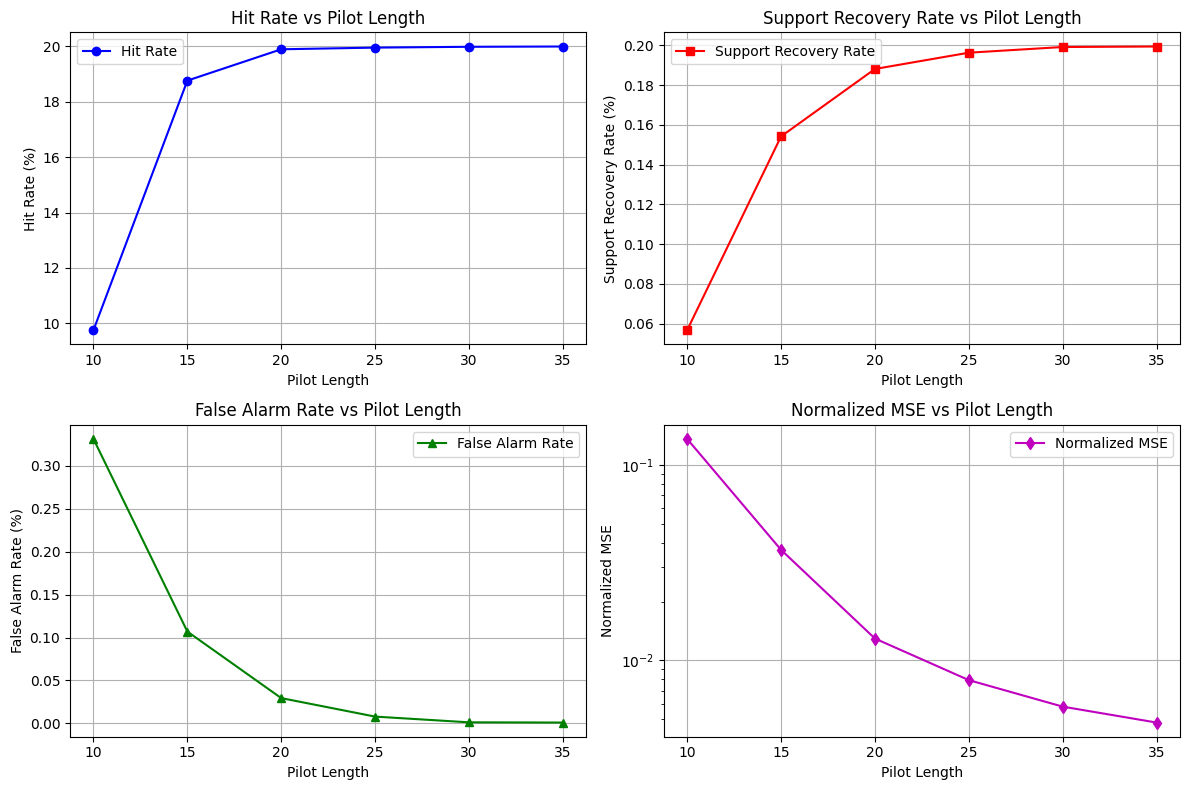

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(12, 8))

# Plot Hit Rate
plt.subplot(2, 2, 1)
plt.plot(pilot_length_values, avg_hit_rate_casbl, marker='o', linestyle='-', color='b', label='Hit Rate')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Miss Detection Rate
plt.subplot(2, 2, 2)
plt.plot(pilot_length_values, avg_support_recovery_rate_casbl, marker='s', linestyle='-', color='r', label='Support Recovery Rate')
plt.xlabel("Pilot Length")
plt.ylabel("Support Recovery Rate (%)")
plt.title("Support Recovery Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate
plt.subplot(2, 2, 3)
plt.plot(pilot_length_values, avg_false_alarm_rate_casbl, marker='^', linestyle='-', color='g', label='False Alarm Rate')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE
plt.subplot(2, 2, 4)
plt.plot(pilot_length_values, avg_norm_mse_casbl, marker='d', linestyle='-', color='m', label='Normalized MSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
